In [1]:
from google.colab import drive
 
# This will prompt for authorization.
drive.mount('/mydrive')

# Load the Drive helper and mount
from google.colab import drive
 
# This will prompt for authorization.
drive.mount('/mygoogledrive')
 
!ls /mygoogledrive
 
!ls '/mygoogledrive/My Drive'
import tensorflow as tf
import multiprocessing as mp
if mp.get_start_method() != "forkserver":
    mp.set_start_method("forkserver", force=True)
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
 
mydrive_path = '/mygoogledrive/My Drive'
mydrive = os.listdir(mydrive_path)
 
for f in mydrive: 
  print(f)

from google.colab import files
os.chdir('/mygoogledrive/My Drive/')
os.getcwd()

Mounted at /mydrive
Mounted at /mygoogledrive
MyDrive
 Arcdis				      'splith (1).ipynb'
 arcroc1000s64.ipynb		       splith.ipynb
 arcs64.ipynb			       testdis_bin
 checkpoints			       testdisseg
'Colab Notebooks'		       testdisseg.zip
'distsnce seg and cut.zip'	       testdis.txt
 generat_bin4480.ipynb		       traindis_bin
 Iris_recognition_with_Arcface.ipynb   traindisseg
 losses.py			       traindisseg_shuffle.npz
 models.py			       traindisseg.zip
 myCallbacks.py			       traindis.txt
 plot.py			       validdisseg
 pltitdgpu1000_s10.ipynb	       validdisseg.zip
Iris_recognition_with_Arcface.ipynb
pltitdgpu1000_s10.ipynb
Colab Notebooks
distsnce seg and cut.zip
splith (1).ipynb
splith.ipynb
traindisseg.zip
validdisseg.zip
testdisseg.zip
traindisseg
testdisseg
validdisseg
traindis.txt
traindis_bin
plot.py
models.py
losses.py
myCallbacks.py
testdis.txt
testdis_bin
generat_bin4480.ipynb
traindisseg_shuffle.npz
Arcdis
checkpoints
arcs64.ipynb
arcroc1000s64.ipynb


'/mygoogledrive/My Drive'

In [2]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from glob2 import glob
from skimage import transform
from skimage.io import imread, imsave
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def eval_folder(model_file, data_path, batch_size=32, save_embeddings=None, debug=True):
    if save_embeddings and os.path.exists(save_embeddings):
        print(">>>> Reloading from backup:", save_embeddings)
        aa = np.load(save_embeddings)
        embs, imm_classes, filenames = aa["embs"], aa["imm_classes"], aa["filenames"]
        embs, imm_classes = embs.astype("float32"), imm_classes.astype("int")

    else:
        img_shape = (200, 200)
        mm = tf.keras.models.load_model(model_file)
        img_gen = ImageDataGenerator().flow_from_directory(data_path, class_mode='binary', target_size=img_shape, batch_size=batch_size, shuffle=False)
        steps = int(np.ceil(img_gen.classes.shape[0] / img_gen.batch_size))
        filenames = np.array(img_gen.filenames)

        embs, imm_classes = [], []
        for _ in tqdm(range(steps), "Embedding"):
            imm, imm_class = img_gen.next()
            emb = mm((imm - 127.5) * 0.0078125)
            embs.extend(emb)
            imm_classes.extend(imm_class)
        embs, imm_classes = normalize(np.array(embs).astype("float32")), np.array(imm_classes).astype("int")
        if save_embeddings:
            print(">>>> Saving embeddings to:", save_embeddings)
            np.savez(save_embeddings, embs=embs, imm_classes=imm_classes, filenames=filenames)
    if save_embeddings:
        result_name = os.path.splitext(os.path.basename(save_embeddings))[0]
    else:
        result_name = os.path.splitext(os.path.basename(model_file))[0]


    register_ids = np.unique(imm_classes)
    if debug:
        print(">>>> [base info] embs:", embs.shape, "imm_classes:", imm_classes.shape, "register_ids:", register_ids.shape)
    try:
        import cupy as cp
        embs = cp.array(embs)
        dist_func = lambda aa, bb: cp.dot(aa, bb).get()
        if debug:
            print(">>>> Using cupy.")
    except:
        dist_func = lambda aa, bb: np.dot(aa, bb)

    pos_dists, neg_dists, register_base_dists = [], [], []
    for register_id in tqdm(register_ids, "Evaluating"):
        pick_cond = imm_classes == register_id
        pos_embs = embs[pick_cond]
        dists = dist_func(pos_embs, pos_embs.T)
        register_base = dists.sum(0).argmax()
        register_base_dist = dists[register_base]
        register_base_emb = embs[pick_cond][register_base]
        pos_dist = register_base_dist[np.arange(dists.shape[0]) != register_base]

        register_base_dist = dist_func(embs, register_base_emb)
        neg_dist = register_base_dist[imm_classes != register_id]

        pos_dists.extend(pos_dist)
        neg_dists.extend(neg_dist)
        register_base_dists.append(register_base_dist)
        # print(">>> [register info] register_id:", register_id, "register_base_img:", filenames[pick_cond][register_base])
    pos_dists = np.array(pos_dists).astype('float')
    neg_dists = np.array(neg_dists).astype('float')
    register_base_dists = np.array(register_base_dists).T
    if debug:
        print(">>>> pos_dists:", pos_dists.shape, "neg_dists:", neg_dists.shape, "register_base_dists:", register_base_dists.shape)

    accuracy = (register_base_dists.argmax(1) == imm_classes).sum() / register_base_dists.shape[0]
    label = np.concatenate([np.ones_like(pos_dists), np.zeros_like(neg_dists)])
    score = np.concatenate([pos_dists, neg_dists])
    return accuracy, score, label



if __name__ == "__main__":
    import sys
    data_path='/mygoogledrive/MyDrive/testdisseg/'
    model_file='/mygoogledrive/MyDrive/Arcdis/Arcirisdis_mobilenet_basic_testdis_bin_epoch_35_0.921038.h5'
    detection="store_false"
    batch_size=64
    save_embeddings=None
    

    if model_file == None and data_path == None and save_embeddings == None:
        print(">>>> Please seee `--help` for usage")
        sys.exit(1)

    data_path =data_path
   
    accuracy, score, label = eval_folder(model_file, data_path,batch_size, save_embeddings, debug=True)
    print(">>>> top1 accuracy:", accuracy)
    


Found 732 images belonging to 122 classes.


Embedding: 100%|██████████| 12/12 [10:27<00:00, 52.31s/it]


>>>> [base info] embs: (732, 512) imm_classes: (732,) register_ids: (122,)
>>>> Using cupy.


Evaluating: 100%|██████████| 122/122 [00:01<00:00, 64.16it/s]

>>>> pos_dists: (610,) neg_dists: (88572,) register_base_dists: (732, 122)
>>>> top1 accuracy: 0.8729508196721312


In [3]:
from scipy.optimize import brentq
from scipy import interpolate
import matplotlib.pyplot as plt
def plot_tpr_far(score, label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fpr, tpr, _ = roc_curve(label, score)
     
    roc_auc = auc(fpr,tpr)
    eer = brentq(lambda x : 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1)
    eer100=eer*100
    print('Equal Error Rate (EER): %1.3f' %  eer100 )

    fpr_show = [10 ** (-ii) for ii in range(1, 7)[::-1]]
    fpr_reverse, tpr_reverse = fpr[::-1], tpr[::-1]
    tpr_show = [tpr_reverse[np.argmin(abs(fpr_reverse - ii))] for ii in fpr_show]
    print(pd.DataFrame({"FPR": fpr_show, "TPR": tpr_show}).set_index("FPR").T.to_markdown())

    
    
    model_file='/mygoogledrive/MyDrive/mobilenet4/'
    result_name = os.path.splitext(os.path.basename(model_file))[0]
    fig = plt.figure()
    plt.plot(fpr, tpr, lw=1,label="ROC")

    plt.xlim([10 **-6, 0.01])
    plt.fill_between(fpr, tpr, alpha=0.2,color='grey',label="%s AUC = %0.4f%%" % (result_name, roc_auc * 100))
    plt.xscale("log")
    plt.xticks(fpr_show)
    plt.xlabel("False Positive Rate",fontweight='bold')
    plt.ylim([0.8, 1.0])  # use a smaller ylim here, [0, 1] --> [0.8, 1]
    plt.yticks(np.linspace(0.8, 1.0, 10, endpoint=True))
    plt.ylabel("True Positive Rate",fontweight='bold')
    plt.plot([eer, eer], [0, 1 - eer], linestyle='--', label='EER=%0.4f' % (eer))
    plt.grid(linestyle="--", linewidth=1)

    log_fpr= 1 / 10 ** np.arange(0, 10, 0.01)  # Plot where fpr == tpr, use log x
    plt.plot(fpr, 1- fpr)  # fpr = 1 - tpr

    plt.title("ROC (cosface)",fontweight='bold')
    plt.legend(loc='upper left')
    plt.tight_layout()

    return fig

Equal Error Rate (EER): 3.770
|     |    1e-06 |    1e-05 |   0.0001 |    0.001 |     0.01 |      0.1 |
|:----|---------:|---------:|---------:|---------:|---------:|---------:|
| TPR | 0.436066 | 0.463934 | 0.542623 | 0.739344 | 0.904918 | 0.972131 |


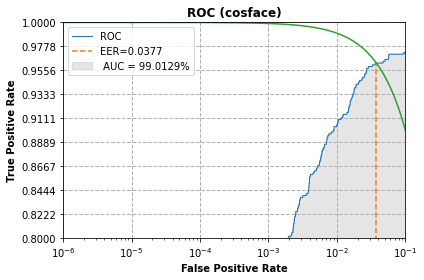

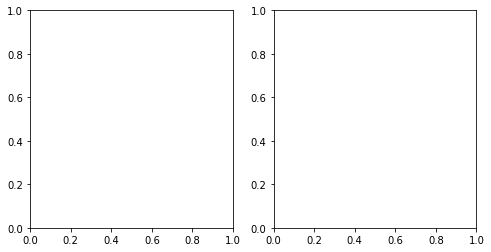

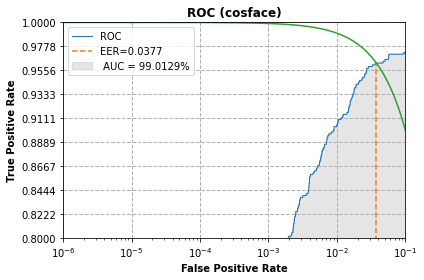

In [4]:
plot_tpr_far(score, label)